# Lectura de la Información
En este notebook nos enfocaremos en extraer la data de los archivos comprimidos y unificar las fuentes de datos. Muchas de los métodos/funciones utilizadas, serán cargadas de un archivo utils.py previamente generado para evitar sobrecarga de código en este notebook.

### Cargar librerías necesarias

In [16]:
from utils import *
import shutil
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Listar archivos comprimidos y extraer archivos

In [2]:
files=[i for i in os.listdir("../") if i.endswith(".zip")] ## ../ hace referencia a un nivel atrás al actual, en donde se encuentran los archivos .zip
_=[shutil.unpack_archive(f'../{i}', f'../data/') for i in files]

In [3]:
##extraer paths de cada archivo csv
filepaths=get_csv_filepaths([i.replace(".zip","") for i in files])

### Para leer las fuentes de datos se definirán grupos de archivos denotados por la variable filegroups

In [5]:
##NOTA: NO EJECUTAR SI PREVIAMENTE SE HAN GENERADO LOS ARCHIVOS .pickle por filegroup
filegroups=['personajuridica','personanatural','produccion','recaudo','siniestro']     
data={}
for filegp in filegroups:
    data[filegp]=read_by_filegroup(filegp,filepaths,save_output=True)

In [4]:
##leer archivos pickle (Checkpoint)
filegroups=['personajuridica','personanatural','produccion','recaudo','siniestro']
data={}
for filegp in filegroups:
    data[filegp]=pd.read_pickle(f"{filegp}.pickle",compression="gzip")

### Lectura información tipo de Polizas

In [5]:
FILENAME_POLIZAS="../CODIGOS PRODUCTOS SISE.xls"
tipo_poliza,tipo_subramo,tipo_prod=pd.read_excel(FILENAME_POLIZAS,sheet_name="tipo poliza",dtype={'cod_ramo': int, 'cod_tipo_poliza': int,'txt_desc':str}),\
                                    pd.read_excel(FILENAME_POLIZAS,sheet_name="productos rc subramo",dtype={'cod_ramo': int, 'cod_subramo': int,'txt_desc':str}),\
                                    pd.read_excel(FILENAME_POLIZAS,sheet_name="productos 3g",dtype={'ramo': int, 'codigo': str})
tipo_poliza.head()

,cod_ramo,cod_tipo_poliza,txt_desc
0,1,1,SECTOR OFICIAL
1,1,2,SECTOR PRIVADO
2,1,3,GLOBAL SECTOR OFICIAL
3,1,4,GLOBAL SECTOR PRIVADO
4,1,5,POLICIA NACIONAL


## Esquema de generación de la variable objetivo: churn

- Se deben explorar los campos que permiten unir las diversas fuentes de información, para ello deberá explorarse el código de asegurado o el número de la póliza
- Debido a que solo se tiene un año de historia, debemos tomar un periodo base y observar 12 meses después el comportamiento de los asegurados, para encontrar si renovaron o no (churn) su poliza. A través de este análisis generaremos la variable objetivo. Esto puede observarse en el siguiente gráfico. 

![img](images/caso_uso_previsora.jpg)


- Sólo serán tenidas en cuenta las pólizas de 12 meses de duración




In [6]:
##detectar columnas tipo fecha y convertirlas a tipo datetime

date_cols=[i for i in data['produccion'].columns.values if "fecha" in i.lower()]

## crear una copia del dataframe para generar reproducibilidad
data_prod=data['produccion'].drop_duplicates().copy()

def col_to_dateutc(column,trim=False):
    if trim:
        return pd.to_datetime(column,errors="coerce").dt.strftime('%m-%Y')
    else:
        return pd.to_datetime(column,errors="coerce")

for col in date_cols:
    data_prod.loc[:,col]=col_to_dateutc(data_prod[col])
    data_prod.loc[:,col+"trim"]=col_to_dateutc(data_prod[col],trim=True)


print("Total filas antes de remover duplicados: ",data['produccion'].shape[0])
print("Total filas después de remover duplicados: ",data_prod.shape[0])

Total filas antes de remover duplicados:  1054290
Total filas después de remover duplicados:  1003437


In [7]:
##obtener descripción tipo de poliza y de producto
#tipo_poliza,tipo_subramo,tipo_prod
data_prod=data_prod.merge(tipo_poliza.rename(columns={'txt_desc':'tipo_poliza_name'}),how="left",left_on=['RamoTecnico__c','Tipo_poliza_c'],right_on=['cod_ramo','cod_tipo_poliza'])
data_prod.tipo_poliza_name.value_counts(ascending=False)

S.O.A.T                                             696478
INDIVIDUAL                                           92538
RESPONSABILIDAD CIVIL                                41957
DE DAÑOS TRADICIONAL                                 22014
DE DAÑOS                                             19744
DE DEUDORES HIPOTECARIOS                             14423
FLOTANTE                                             11653
NORMAL                                               10613
DE DISPOSICIONES LEGALES                              9578
UNICA A FAVOR DE ENTIDADES ESTATALES                  8325
 DE DAÑOS                                             7938
COLECTIVA                                             7393
GLOBAL SECTOR PRIVADO                                 6473
TODO RIESGO DE OBRAS CIVILES DAÑOS MATERIALES         6010
GLOBAL SECTOR OFICIAL                                 3328
ECOPETROL                                             3250
SECTOR PRIVADO                                        26

In [8]:
##Añadir descripción tipo producto

def try_convert(num):
    try: 
        val=str(int(num))
        return val
    except:
        return "99999"
        
data_prod.loc[:,'Producto__c']=data_prod.Producto__c.apply(lambda d: try_convert(d)) ## se debe realizar un paso previo ya que el Producto__c está con valores decimales

data_prod=data_prod.merge(tipo_prod.rename(columns={'descripcion reducida':'tipo_prod_desc'}).drop(columns="producto"),how="left",left_on=['RamoTecnico__c','Producto__c'],right_on=['ramo','codigo'])
data_prod.tipo_prod_desc.value_counts()

CONVENIOS          23987
AU DED UNIC LIV    12348
DISP LEGALES        9578
AU EXCEPCIONES      8402
PREVICOLECTIVAS     4300
CUM ENT ESTATAL     3305
MA GLOB OFICIAL     2698
CUMP ECOPETROL      2679
TR MERCANCIAS       2642
LICITACIONES        2521
CUM PRIVADO         1939
PREVILIVIANOS       1922
AU DELEGADO SUC     1633
AU LV CARG-PUBL     1028
INCENDIO             924
CARIÐO VERDADER      866
SER OFERT ESTAT      847
TR TRAYECTOS         705
PREVIFAMILIAS        633
AU AMBULANCIAS       581
AU SERVIDOR PUB      569
SER OFERT ECOPE      567
SER OFERT PRIVA      362
RC EXTRACONTRAC      303
SUSTRACCION          300
TR VALORES           239
CU COLJUEGOS         209
CUM. EMP. SERV       198
MA GLOB PRIVADO      165
AU PREVIDORADOS      159
DERV CONTR ESTA      133
SER OFERT ESP        110
CORRIENTE DEBIL       52
COMB MCIAS PELI       43
R.C.E. AUTOS          24
DERV CONTR PRIV       21
CUM A FAVOR ANI       17
ROTURA DE MAQUI       16
IND.PREVITAXIS        14
IND.PREVIPESADO        3


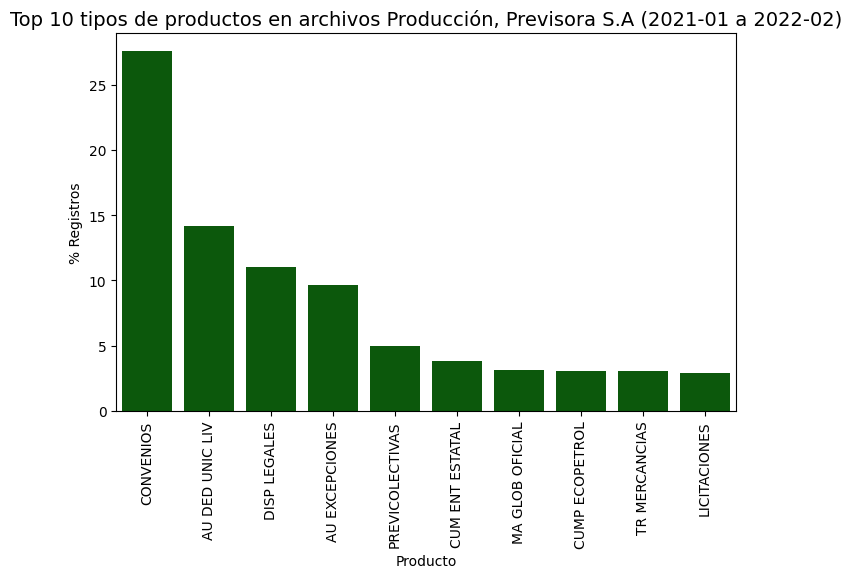

In [40]:
data_tipo_prod=data_prod.tipo_prod_desc.value_counts(normalize=True).head(10).reset_index()

f,ax=plt.subplots(figsize=(8,5),dpi=100)
sns.barplot(x=data_tipo_prod['index'],y=data_tipo_prod['tipo_prod_desc']*100,data=data_tipo_prod,ax=ax,color="darkgreen");
ax.set_title("Top 10 tipos de productos en archivos Producción, Previsora S.A (2021-01 a 2022-02)",size=14)
ax.set_xlabel("Producto")
ax.set_ylabel("% Registros")
plt.xticks(rotation=90);

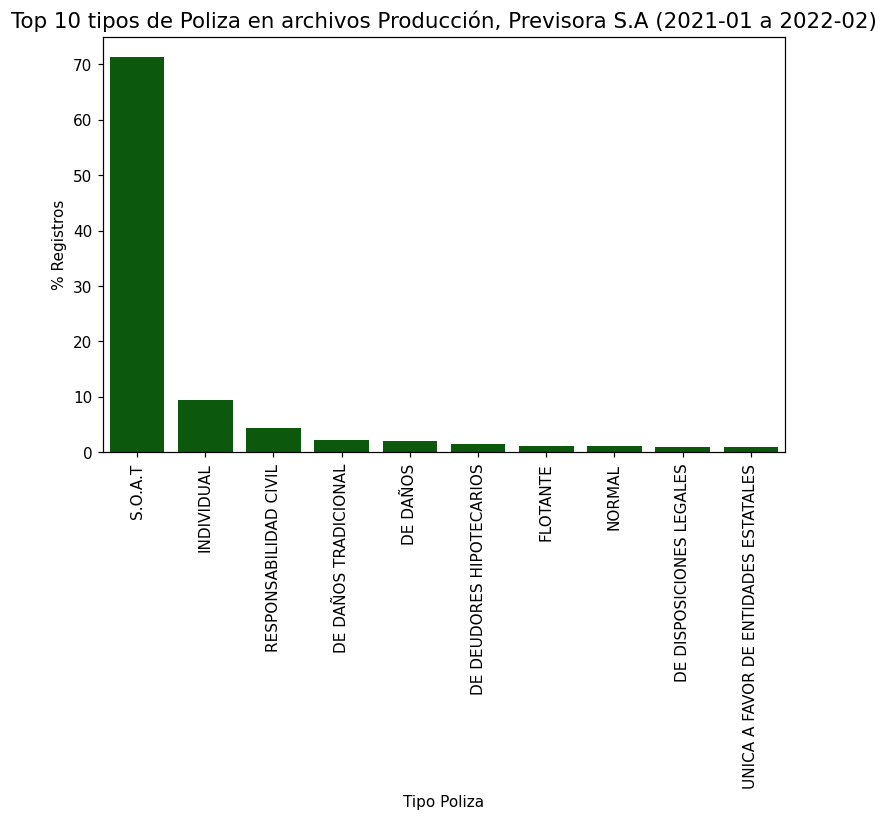

In [42]:
data_tipo_poliza=data_prod.tipo_poliza_name.value_counts(normalize=True).head(10).reset_index()

f,ax=plt.subplots(figsize=(8,5),dpi=110)
sns.barplot(x=data_tipo_poliza['index'],y=data_tipo_poliza['tipo_poliza_name']*100,data=data_tipo_poliza,ax=ax,color="darkgreen");
ax.set_title("Top 10 tipos de Poliza en archivos Producción, Previsora S.A (2021-01 a 2022-02)",size=14)
ax.set_xlabel("Tipo Poliza")
ax.set_ylabel("% Registros")
plt.xticks(rotation=90);

In [11]:
## eliminar columnas innecesarias generadas en los merge
data_prod.drop(columns=['cod_ramo','cod_tipo_poliza','ramo','codigo'],inplace=True)

In [9]:
#calcular vigencia en días de la poliza, para el MVP asumiremos solo polizas de 365 días.
data_prod.loc[:,'vigencia_dias']=data_prod.apply(lambda d: (d['FechaFinVigencia__c']-d['FechaInicioVigencia__c']).days,axis=1)
data_prod_365=data_prod.query("""vigencia_dias==365""").copy()

### Cálculo de variable objetivo: churn

Para este MVP usaremos las polizas cuya vigencia empieza en enero o febrero de 2021 y observaremos si en el mes de su vencimiento, se observan o no nuevas polizas para el mismo código de asegurado (Asegurado__c).

In [7]:
fecha_inicio="01-2021" ##fecha para iniciar el monitoreo de polizas un año después
fecha_fin="01-2022"  ##fecha para finalizar el monitoreo de las pólizas
emisiones_inicio=data_prod_365.query(f'FechaInicioVigencia__ctrim=="{fecha_inicio}"')
emisiones_final=data_prod_365.query(f'FechaInicioVigencia__ctrim=="{fecha_fin}"')
print(f"Total emisiones en {fecha_inicio} : {len(set(emisiones_inicio.NumeroPoliza__c.values))} polizas")
print(f"Total emisiones al finalizar el monitoreo en {fecha_fin} : {len(set(emisiones_final.NumeroPoliza__c.values))} polizas")

Total emisiones en 01-2021 : 2173 polizas
Total emisiones al finalizar el monitoreo en 01-2022 : 38892 polizas


In [20]:
churn_data=emisiones_inicio.merge(emisiones_final[['Asegurado__c','NumeroPoliza__c','vigencia_dias']].rename(columns={'vigencia_dias':'end_vig'}),how="left",on=['Asegurado__c','NumeroPoliza__c'])

In [24]:
churn_data.loc[:,'churn']=churn_data.end_vig.isnull()